# Title: Deep compressed sensing on spectroscopic profiling data using variational auto-encoder


# Introduction

CS, CS by generative models 

# Method

## CS

Spectroscopic 

## VAE 

model, theory

## VAE-CS

model structure, framework

# Case Study

## Instrument

## Dataset

## Hyper-parameter Optimization

## Result

## Comparison with non-adaptive bases

# Disussions and Conclusion

---

# Compressed sensing Theory

pip install cs1==0.2.1


## VAE-CS

Sampling
$$ xs = \Phi x ,\quad for \quad \Phi_{k*N}, k > （4 * non-sparsity） $$

Sparsity hypothesis
$$ x = \Psi z $$

Compressed Sensing
$$ x_s = \Phi \Psi z $$

Optimization (LASSO)
$$ minimize \quad  ||z||_1 $$
$$ s.t \quad     x_s = \Phi \Psi z $$

Reconstruction
$$ x = \Psi z $$

-----------

The function `vae_reconstruct()` solves the problem $$\operatorname{argmin}_z \|ΦG(z)-xs\|^2 重建误差 $$


where:  
* G(z)是解码器, G相当于变换基 Ψ, G(z)即Ψz，等于xr
* $x \in \mathbb R^n$ is the input signal.  
* $Φ$ is an $m\times n$ matrix with i.i.d $\mathcal N(0,\frac 1m)$ entries. 感知矩阵 Φ
* $\eta \in \mathbb R^m$ is a random Gaussian noise with i.i.d $\mathcal N(0,\frac{0.1}{\sqrt m})$ entries.
* $xs = Φx$ is the measurement vector.

We follow the same exact procedure as in the paper: sample $10$ random initial $z$'s and solve the problem for each initialization using Adam optimizer with learning rate $0.01$. Gradients are computed automatically using Pytorch's `autograd` library. We return the $z$ that yields lowest measurement error at the end.

Adding `requires_grad_(False)` on all the variables except `z` ensures that only `z` is being optimized on.


## Two flavors of the sensing matrix $Φ$

#### random binary sensing matrix vs. random Gaussian sensing matrix

" A sensing matrix maps input vector to measurement vector through linear wighted summation of input. What makes a specefic matrix good, is application dependent. Now, both distributions more or less satisfy RIP. However hardware implementation of the Bernoulli matrix (binary or bipolar) is much much easier especially in analog domain. A Bernoulli wight is either 0 or 1 (or -1/1 in case of polar Bernoulli), but a Gaussian wight is a floating point figure. Multiplication of a flouting point number either in digital or analog, is resource consuming, while multiplication of a Bernoulli wight is feasible through implementation of a simple switch in analog domain or and instruction in digital. "

--------

In [1]:
import cs1
cs1.__version__

'0.2.1'

# Hyper-parameters

## VAE Model Topology hparams: 

    batch_size: Used to create pytorch `DataLoader` objects. affact the training process.  
    h_dim1 : hidden layer 1 nodes  
    h_dim2 : hidden layer 2 nodes. set 0 if don't use this layer.    
    z_dim : the latent variable layer dimensionality  

These affect the model complexity / topology.  

## CS Sensing hparams

    k : sampling percentage  
    PHI_flavor : 'gaussian' or 'bernoulli'  

## CS Reconstruction hparams: 

    lr : learning rate  
    regularization : regularization  
    iterations : gradient descent iterations  
    N : how many runs to construct each signal  
    add_noise : whether add white noise [reduce overfiting risk]

These are reconstruction hyper-parameters



# Construct and train two VAE models

load dataset from 7344_Y5Y26.csv
X.shape (121, 2089)  y.shape (121,)


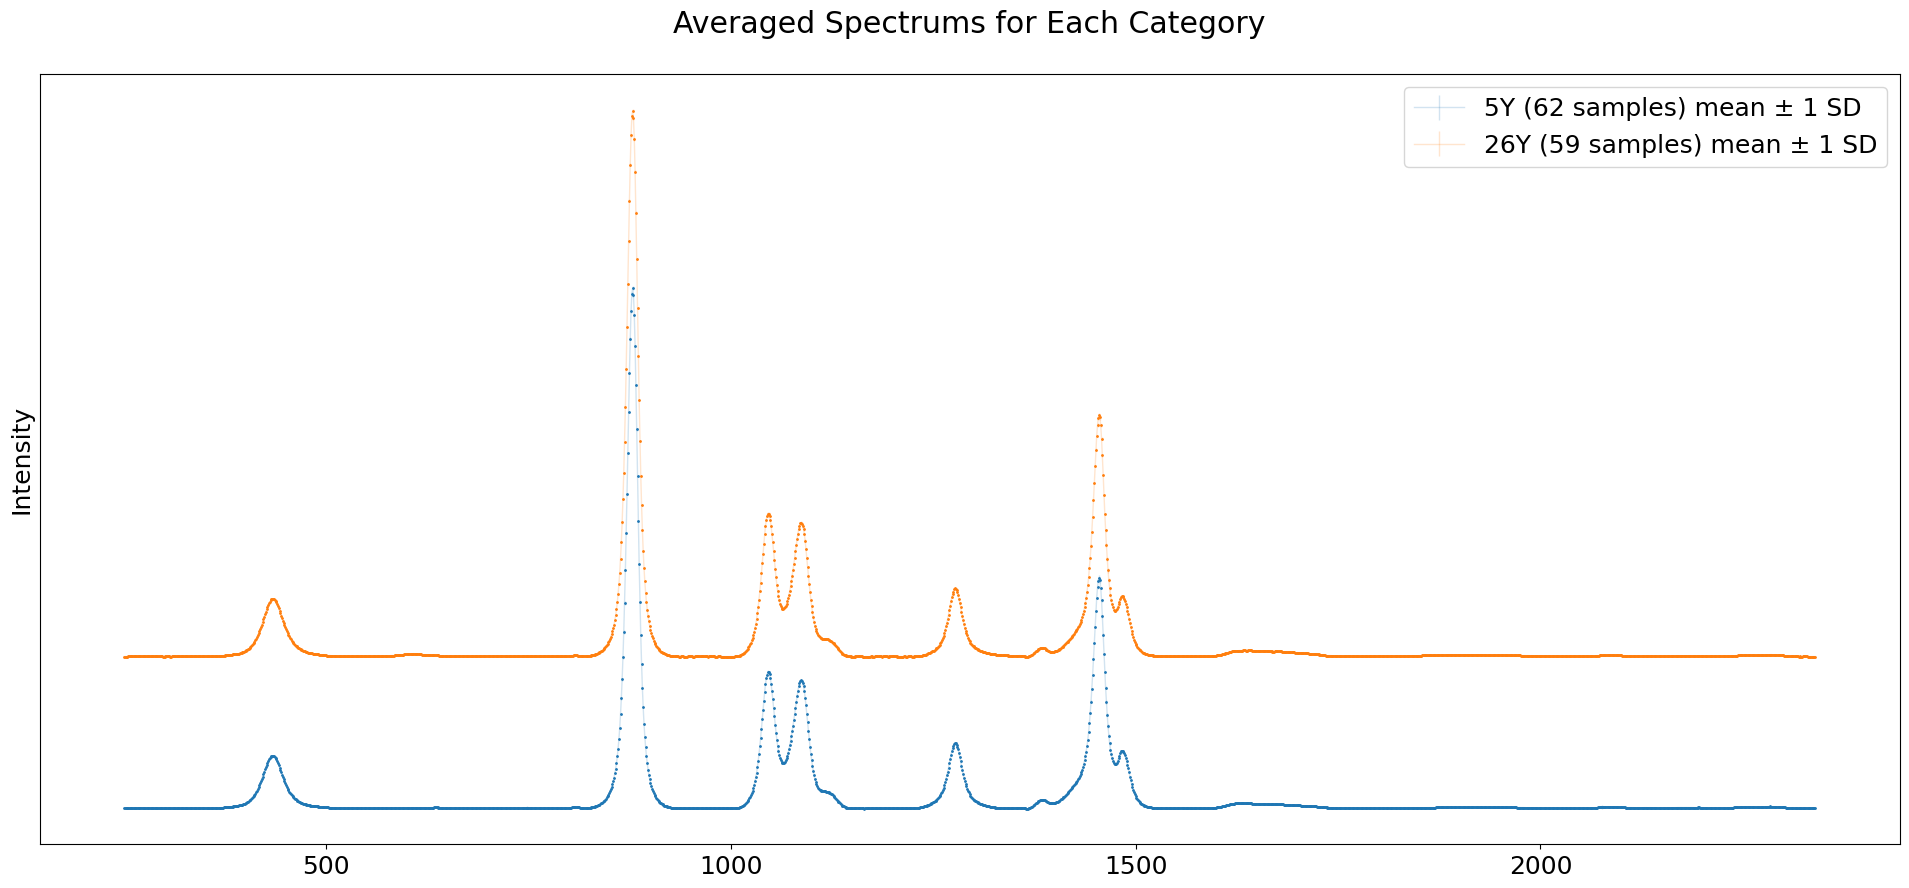

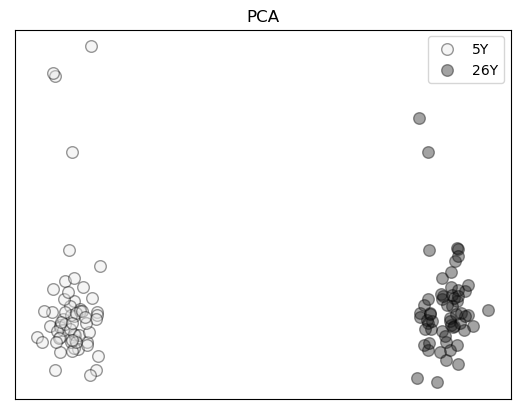

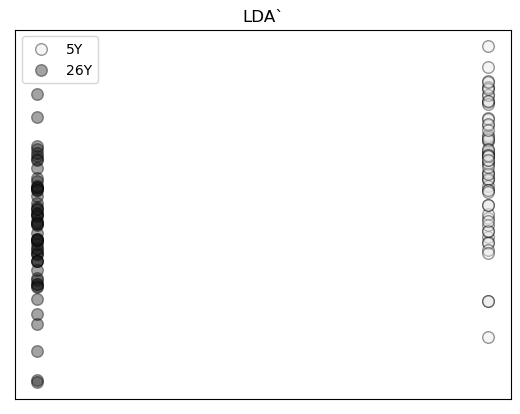

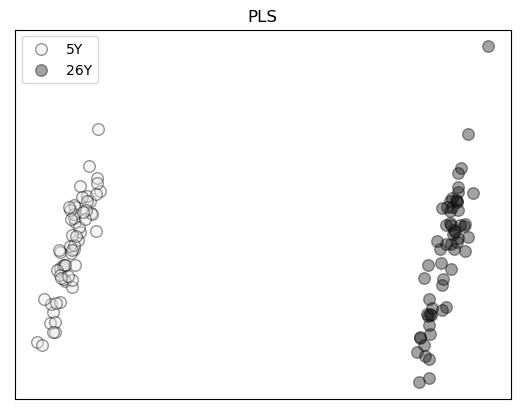

7344_Y5Y26.csv - Raman spectroscopic profiling dataset of 
5-year and 26-year Gujing Tribute vintage liquors. 

y = 0: 5-year
y = 1: 26-year

Each sample has 2088 Raman wavenumbers, ranging from 251 to 2338 cm-1.  
Three outlier samples were removed.   

--------------------
If you use this data set, please add the reference: 
[1] A unified classifiability analysis framework based on meta-learner and its application in spectroscopic profiling data [J]. Applied Intelligence, 2021, doi: 10.1007/s10489-021-02810-8


LogisticRegressionCV score on entire dataset: 1.0
Train Epoch: 1 [0/96 (0%)]	Loss: 1453.289673
====> Epoch: 1 Average loss: 1429.3734
====> Test set loss: 1349.8933
Train Epoch: 2 [0/96 (0%)]	Loss: 1378.599731
====> Epoch: 2 Average loss: 1281.5589
====> Test set loss: 1014.5484
Train Epoch: 3 [0/96 (0%)]	Loss: 1097.445190
====> Epoch: 3 Average loss: 835.0144
====> Test set loss: 127.6865
Train Epoch: 4 [0/96 (0%)]	Loss: 260.309906
====> Epoch: 4 Average loss: 389.3225
====> Test set loss: -501.1283
Train Epoch: 5 [0/96 (0%)]	Loss: -454.106079
====> Epoch: 5 Average loss: -645.9222
====> Test set loss: -1329.7455
Train Epoch: 6 [0/96 (0%)]	Loss: -1042.898193
====> Epoch: 6 Average loss: -1334.1082
====> Test set loss: -3853.7281
Train Epoch: 7 [0/96 (0%)]	Loss: -2038.281250
====> Epoch: 7 Average loss: -3530.4370
====> Test set loss: -6356.7250
Train Epoch: 8 [0/96 (0%)]	Loss: -5349.280762
====> Epoch: 8 Average loss: -6671.3929
====> Test set loss: -7559.0775
Train Epoch: 9 [0/96 (0%

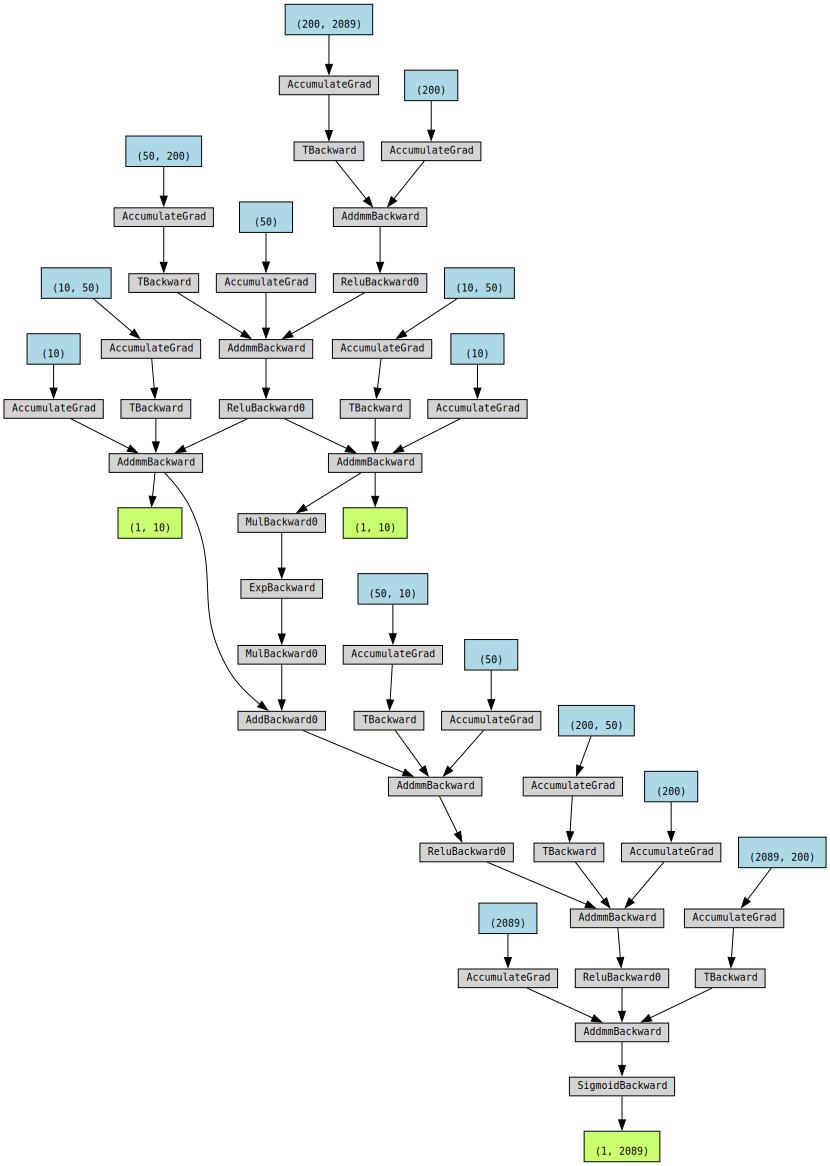

Train Epoch: 1 [0/96 (0%)]	Loss: 1467.171753
====> Epoch: 1 Average loss: 1418.0876
====> Test set loss: 1291.2341
Train Epoch: 2 [0/96 (0%)]	Loss: 1243.014771
====> Epoch: 2 Average loss: 1133.6817
====> Test set loss: 810.2160
Train Epoch: 3 [0/96 (0%)]	Loss: 641.255371
====> Epoch: 3 Average loss: 484.8241
====> Test set loss: -142.2702
Train Epoch: 4 [0/96 (0%)]	Loss: -555.161377
====> Epoch: 4 Average loss: -514.6123
====> Test set loss: -1177.1870
Train Epoch: 5 [0/96 (0%)]	Loss: -1938.051270
====> Epoch: 5 Average loss: -1987.0134
====> Test set loss: -2339.6683
Train Epoch: 6 [0/96 (0%)]	Loss: -2544.698730
====> Epoch: 6 Average loss: -3666.8887
====> Test set loss: -4173.1209
Train Epoch: 7 [0/96 (0%)]	Loss: -4615.562500
====> Epoch: 7 Average loss: -5453.9443
====> Test set loss: -5422.4163
Train Epoch: 8 [0/96 (0%)]	Loss: -7309.665527
====> Epoch: 8 Average loss: -7750.4504
====> Test set loss: -7346.5094
Train Epoch: 9 [0/96 (0%)]	Loss: -10219.761719
====> Epoch: 9 Average 

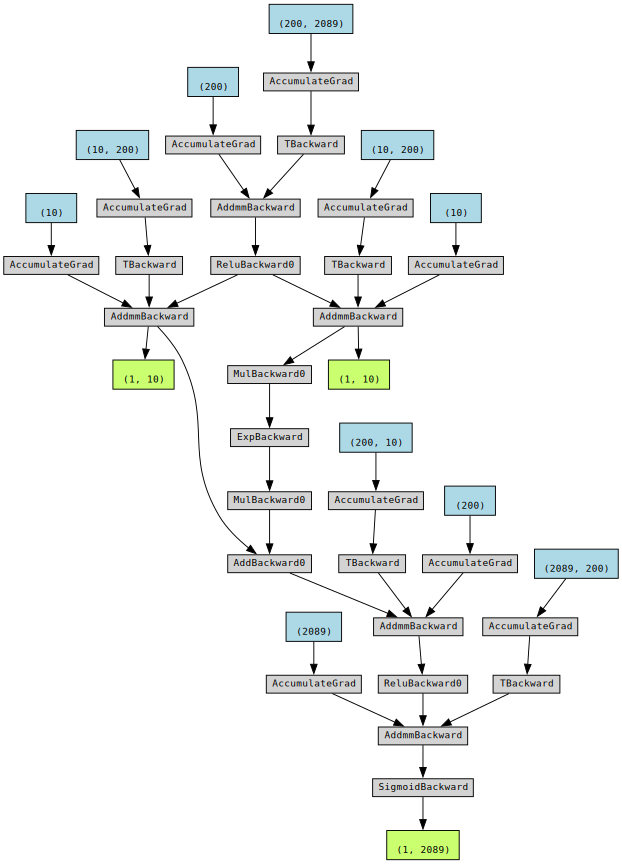

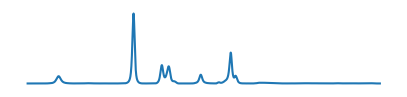

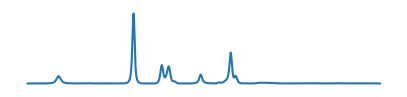

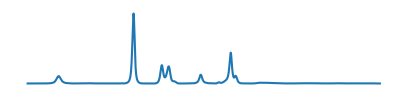

In [2]:
from cs1.basis.adaptive import vae
X, y, scaler, clf, model1, model2 = vae.build_vae()

---

# Try VAE Model 1

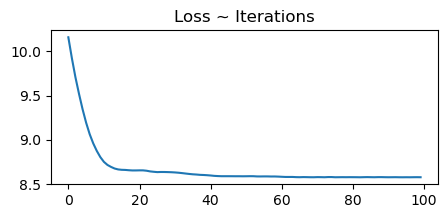

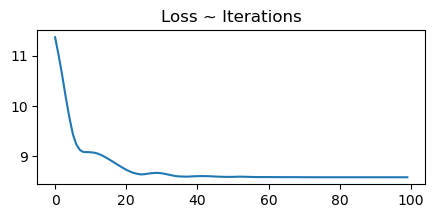

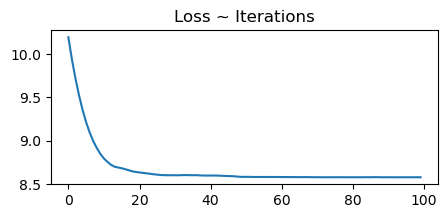

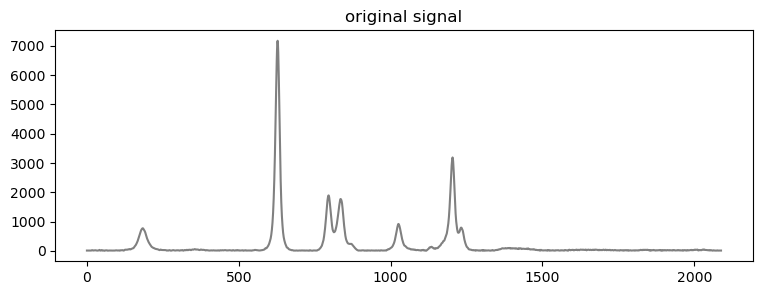

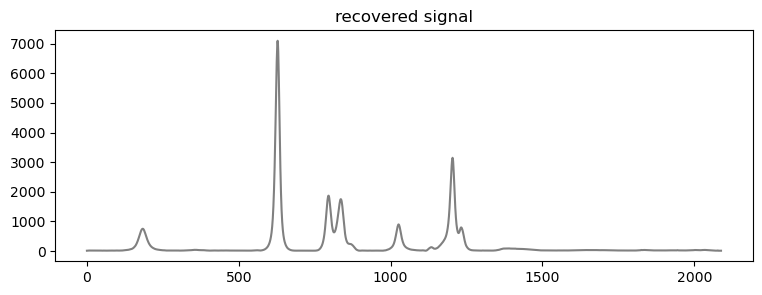

In [3]:
vae.VAE_Sensing_n_Recovery(model1, X[0], scaler = scaler, k = 0.01,
                            PHI_flavor = 'gaussian', 
                            add_noise = True, 
                            lr = 0.1, regularization = 0.1, 
                            iterations = 100, N = 3, debug_mode = True)

# Hparam optimization using grid search strategy

## Round 1 - A rough search

In [ ]:
dic, best_hparams, best_acc, sorted_dic = vae.vae_cs_grid_search(model, X, y,
ks = [0.001, 0.01, 0.1], 
PHI_flavors = ['gaussian', 'bernoulli'], 
add_noises = [False, True],
lrs = [0.01, 0.1],
regularizations = [0, 0.1, 1],
iterationss = [500],
Ns = [3])

LogisticRegressionCV score on entire dataset: 1.0

Grid Search Loop: 0.001 gaussian False 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:08<00:00,  3.05s/it]


Acc: 0.7272727272727273
Acc improved from 0 to 0.7272727272727273. Update best hparams : (0.001, 'gaussian', False, 0.01, 0, 500, 3)

Grid Search Loop: 0.001 gaussian False 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:06<00:00,  3.03s/it]


Acc: 0.628099173553719

Grid Search Loop: 0.001 gaussian False 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:06<00:00,  3.03s/it]


Acc: 0.5537190082644629

Grid Search Loop: 0.001 gaussian False 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:07<00:00,  3.04s/it]


Acc: 0.6363636363636364

Grid Search Loop: 0.001 gaussian False 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:07<00:00,  3.04s/it]


Acc: 0.6942148760330579

Grid Search Loop: 0.001 gaussian False 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:07<00:00,  3.03s/it]


Acc: 0.6115702479338843

Grid Search Loop: 0.001 gaussian True 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:06<00:00,  3.03s/it]


Acc: 0.6363636363636364

Grid Search Loop: 0.001 gaussian True 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:06<00:00,  3.03s/it]


Acc: 0.6942148760330579

Grid Search Loop: 0.001 gaussian True 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:06<00:00,  3.03s/it]


Acc: 0.628099173553719

Grid Search Loop: 0.001 gaussian True 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:07<00:00,  3.03s/it]


Acc: 0.6942148760330579

Grid Search Loop: 0.001 gaussian True 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 0.5867768595041323

Grid Search Loop: 0.001 gaussian True 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:59<00:00,  3.47s/it]


Acc: 0.5785123966942148

Grid Search Loop: 0.001 bernoulli False 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [07:23<00:00,  3.67s/it]


Acc: 0.7768595041322314
Acc improved from 0.7272727272727273 to 0.7768595041322314. Update best hparams : (0.001, 'bernoulli', False, 0.01, 0, 500, 3)

Grid Search Loop: 0.001 bernoulli False 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [07:20<00:00,  3.64s/it]


Acc: 0.7520661157024794

Grid Search Loop: 0.001 bernoulli False 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [07:13<00:00,  3.59s/it]


Acc: 0.6859504132231405

Grid Search Loop: 0.001 bernoulli False 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:30<00:00,  3.22s/it]


Acc: 0.6776859504132231

Grid Search Loop: 0.001 bernoulli False 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:30<00:00,  3.23s/it]


Acc: 0.7603305785123967

Grid Search Loop: 0.001 bernoulli False 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:32<00:00,  3.24s/it]


Acc: 0.6033057851239669

Grid Search Loop: 0.001 bernoulli True 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 0.71900826446281

Grid Search Loop: 0.001 bernoulli True 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:07<00:00,  3.04s/it]


Acc: 0.7272727272727273

Grid Search Loop: 0.001 bernoulli True 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:09<00:00,  3.05s/it]


Acc: 0.5702479338842975

Grid Search Loop: 0.001 bernoulli True 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.07s/it]


Acc: 0.7272727272727273

Grid Search Loop: 0.001 bernoulli True 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:13<00:00,  3.08s/it]


Acc: 0.6776859504132231

Grid Search Loop: 0.001 bernoulli True 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:09<00:00,  3.06s/it]


Acc: 0.5867768595041323

Grid Search Loop: 0.01 gaussian False 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:11<00:00,  3.07s/it]


Acc: 0.9173553719008265
Acc improved from 0.7768595041322314 to 0.9173553719008265. Update best hparams : (0.01, 'gaussian', False, 0.01, 0, 500, 3)

Grid Search Loop: 0.01 gaussian False 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:09<00:00,  3.05s/it]


Acc: 0.9338842975206612
Acc improved from 0.9173553719008265 to 0.9338842975206612. Update best hparams : (0.01, 'gaussian', False, 0.01, 0.1, 500, 3)

Grid Search Loop: 0.01 gaussian False 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 0.9090909090909091

Grid Search Loop: 0.01 gaussian False 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 0.9256198347107438

Grid Search Loop: 0.01 gaussian False 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:09<00:00,  3.05s/it]


Acc: 0.9256198347107438

Grid Search Loop: 0.01 gaussian False 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 0.9256198347107438

Grid Search Loop: 0.01 gaussian True 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 0.9173553719008265

Grid Search Loop: 0.01 gaussian True 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:25<00:00,  3.18s/it]


Acc: 0.9669421487603306
Acc improved from 0.9338842975206612 to 0.9669421487603306. Update best hparams : (0.01, 'gaussian', True, 0.01, 0.1, 500, 3)

Grid Search Loop: 0.01 gaussian True 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:29<00:00,  3.22s/it]


Acc: 0.8429752066115702

Grid Search Loop: 0.01 gaussian True 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:13<00:00,  3.08s/it]


Acc: 0.9256198347107438

Grid Search Loop: 0.01 gaussian True 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:12<00:00,  3.08s/it]


Acc: 0.9669421487603306

Grid Search Loop: 0.01 gaussian True 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 0.8677685950413223

Grid Search Loop: 0.01 bernoulli False 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:11<00:00,  3.07s/it]


Acc: 0.9586776859504132

Grid Search Loop: 0.01 bernoulli False 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:11<00:00,  3.07s/it]


Acc: 0.9421487603305785

Grid Search Loop: 0.01 bernoulli False 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 0.8760330578512396

Grid Search Loop: 0.01 bernoulli False 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:11<00:00,  3.07s/it]


Acc: 0.9338842975206612

Grid Search Loop: 0.01 bernoulli False 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:11<00:00,  3.07s/it]


Acc: 0.9752066115702479
Acc improved from 0.9669421487603306 to 0.9752066115702479. Update best hparams : (0.01, 'bernoulli', False, 0.1, 0.1, 500, 3)

Grid Search Loop: 0.01 bernoulli False 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:11<00:00,  3.07s/it]


Acc: 0.8512396694214877

Grid Search Loop: 0.01 bernoulli True 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:12<00:00,  3.08s/it]


Acc: 0.9256198347107438

Grid Search Loop: 0.01 bernoulli True 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:11<00:00,  3.07s/it]


Acc: 0.9338842975206612

Grid Search Loop: 0.01 bernoulli True 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 0.8842975206611571

Grid Search Loop: 0.01 bernoulli True 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.07s/it]


Acc: 0.9256198347107438

Grid Search Loop: 0.01 bernoulli True 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 0.9586776859504132

Grid Search Loop: 0.01 bernoulli True 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:11<00:00,  3.07s/it]


Acc: 0.8677685950413223

Grid Search Loop: 0.1 gaussian False 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:12<00:00,  3.08s/it]


Acc: 1.0
Acc improved from 0.9752066115702479 to 1.0. Update best hparams : (0.1, 'gaussian', False, 0.01, 0, 500, 3)

Grid Search Loop: 0.1 gaussian False 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:14<00:00,  3.09s/it]


Acc: 1.0

Grid Search Loop: 0.1 gaussian False 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:11<00:00,  3.07s/it]


Acc: 1.0

Grid Search Loop: 0.1 gaussian False 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 1.0

Grid Search Loop: 0.1 gaussian False 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:09<00:00,  3.06s/it]


Acc: 1.0

Grid Search Loop: 0.1 gaussian False 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:09<00:00,  3.06s/it]


Acc: 1.0

Grid Search Loop: 0.1 gaussian True 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:09<00:00,  3.05s/it]


Acc: 1.0

Grid Search Loop: 0.1 gaussian True 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:10<00:00,  3.06s/it]


Acc: 1.0

Grid Search Loop: 0.1 gaussian True 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:15<00:00,  3.10s/it]


Acc: 1.0

Grid Search Loop: 0.1 gaussian True 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:15<00:00,  3.11s/it]


Acc: 1.0

Grid Search Loop: 0.1 gaussian True 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:14<00:00,  3.09s/it]


Acc: 1.0

Grid Search Loop: 0.1 gaussian True 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:13<00:00,  3.09s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli False 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:14<00:00,  3.09s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli False 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:14<00:00,  3.10s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli False 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:15<00:00,  3.10s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli False 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:13<00:00,  3.09s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli False 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:20<00:00,  3.14s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli False 0.1 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:13<00:00,  3.09s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli True 0.01 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:14<00:00,  3.09s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli True 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:14<00:00,  3.09s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli True 0.01 1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:11<00:00,  3.07s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli True 0.1 0 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:09<00:00,  3.06s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli True 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:13<00:00,  3.08s/it]


Acc: 1.0

Grid Search Loop: 0.1 bernoulli True 0.1 1 500 3


 55%|███████████████████████████████████████████                                    | 66/121 [4:18:02<06:20,  6.92s/it]

The k is the most important hparam. After k reaches 0.1, the acc is always 100% no matter the other hparams. 

Best hparam combination when k < 0.1 is (0.01, 'bernoulli', False, 0.1, 0.1, 500, 3), ACC = 97%  
The second is (0.01, 'gaussian', True, 0.01, 0.1, 500, 3), ACC = 96%

(1) The Bernoulli sensing matrix can use a bigger learning rate than Gaussian.   
(2) The Gaussian sensing matrix favors adding white noise while Bernoulli does not.  
(3) The Bernoulli sensing matrix performs slightly better than Gaussian with white noise.  
(4) In practice, we also favor Bernoulli more as it is less demanding in the hardware implementation. 

## 2. Round 2 - A more fine-grained search to decide k and other hparams

In [5]:
dic, best_hparams, best_acc, sorted_dic = vae.vae_cs_grid_search(model, X, y,
ks = [0.02, 0.03], # As 0.01 already get 97% acc, we will start from 0.02  
PHI_flavors = ['bernoulli'], 
add_noises = [False],
lrs = [0.1],
regularizations = [0.1],
iterationss = [500],
Ns = [3])

LogisticRegressionCV score on entire dataset: 1.0

Grid Search Loop: 0.02 bernoulli False 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [08:10<00:00,  4.05s/it]


Acc: 0.9752066115702479
Acc improved from 0 to 0.9752066115702479. Update best hparams : (0.02, 'bernoulli', False, 0.1, 0.1, 500, 3)

Grid Search Loop: 0.03 bernoulli False 0.1 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [08:17<00:00,  4.11s/it]

Acc: 1.0
Acc improved from 0.9752066115702479 to 1.0. Update best hparams : (0.03, 'bernoulli', False, 0.1, 0.1, 500, 3)


In [6]:
dic, best_hparams, best_acc, sorted_dic = vae.vae_cs_grid_search(model, X, y,
ks = [0.02, 0.03], # As 0.01 already get 97% acc, we will start from 0.02  
PHI_flavors = ['gaussian'], 
add_noises = [True],
lrs = [0.01],
regularizations = [0.1],
iterationss = [500],
Ns = [3])

LogisticRegressionCV score on entire dataset: 1.0

Grid Search Loop: 0.02 gaussian True 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [07:28<00:00,  3.71s/it]


Acc: 0.9834710743801653
Acc improved from 0 to 0.9834710743801653. Update best hparams : (0.02, 'gaussian', True, 0.01, 0.1, 500, 3)

Grid Search Loop: 0.03 gaussian True 0.01 0.1 500 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [07:17<00:00,  3.62s/it]

Acc: 0.9917355371900827
Acc improved from 0.9834710743801653 to 0.9917355371900827. Update best hparams : (0.03, 'gaussian', True, 0.01, 0.1, 500, 3)


# Conclusion

For Model 1, the best is (0.03, 'bernoulli', False, 0.1, 0.1, 500, 3). Reached 100% ACC.

# Try VAE Model 2

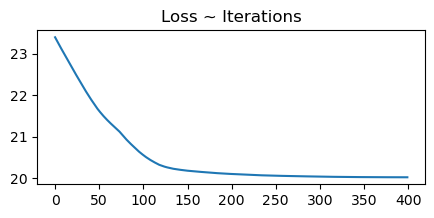

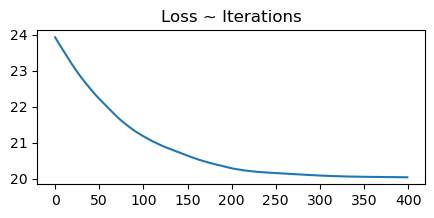

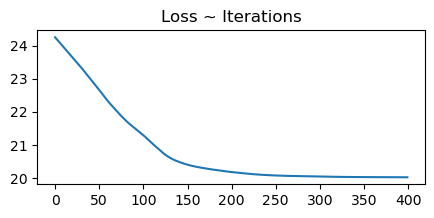

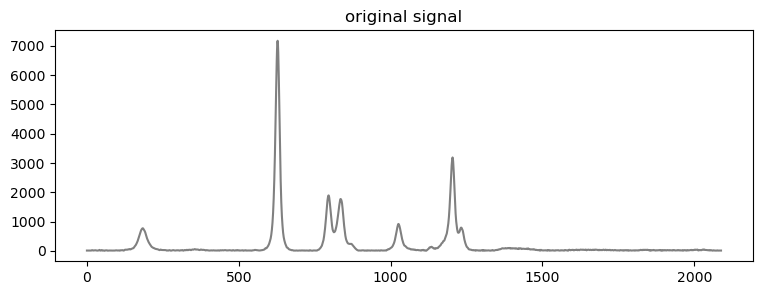

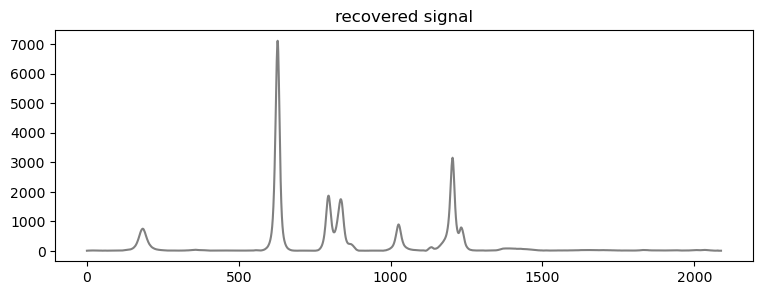

In [6]:
vae.VAE_Sensing_n_Recovery(model2, X[0], scaler = scaler, k = 0.01,
                            PHI_flavor = 'gaussian', 
                            add_noise = True,
                            lr = 0.01, regularization = 0.1,
                            iterations = 400, N = 3, debug_mode = True)

400 iterations is enough for lr 0.01 and above.

In [ ]:
dic, best_hparams, best_acc, sorted_dic = vae.vae_cs_grid_search(model, X, y,
ks = [0.01, 0.02, 0.03],  
PHI_flavors = ['bernoulli', 'gaussian'], 
add_noises = [False, True],
lrs = [0.01, 0.1],
regularizations = [0, 0.1, 1],
iterationss = [400],
Ns = [3])

LogisticRegressionCV score on entire dataset: 1.0

Grid Search Loop: 0.01 bernoulli False 0.01 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:19<00:00,  2.64s/it]


Acc: 0.9917355371900827
Acc improved from 0 to 0.9917355371900827. Update best hparams : (0.01, 'bernoulli', False, 0.01, 0, 400, 3)

Grid Search Loop: 0.01 bernoulli False 0.01 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:08<00:00,  2.55s/it]


Acc: 0.9421487603305785

Grid Search Loop: 0.01 bernoulli False 0.01 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:06<00:00,  2.54s/it]


Acc: 0.5041322314049587

Grid Search Loop: 0.01 bernoulli False 0.1 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.52s/it]


Acc: 0.9504132231404959

Grid Search Loop: 0.01 bernoulli False 0.1 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.52s/it]


Acc: 0.859504132231405

Grid Search Loop: 0.01 bernoulli False 0.1 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:04<00:00,  2.52s/it]


Acc: 0.49586776859504134

Grid Search Loop: 0.01 bernoulli True 0.01 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.52s/it]


Acc: 0.9752066115702479

Grid Search Loop: 0.01 bernoulli True 0.01 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:06<00:00,  2.53s/it]


Acc: 0.8842975206611571

Grid Search Loop: 0.01 bernoulli True 0.01 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:07<00:00,  2.55s/it]


Acc: 0.49586776859504134

Grid Search Loop: 0.01 bernoulli True 0.1 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:06<00:00,  2.53s/it]


Acc: 0.9338842975206612

Grid Search Loop: 0.01 bernoulli True 0.1 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:07<00:00,  2.54s/it]


Acc: 0.859504132231405

Grid Search Loop: 0.01 bernoulli True 0.1 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:06<00:00,  2.53s/it]


Acc: 0.49586776859504134

Grid Search Loop: 0.01 gaussian False 0.01 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:04<00:00,  2.51s/it]


Acc: 0.9586776859504132

Grid Search Loop: 0.01 gaussian False 0.01 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.52s/it]


Acc: 0.859504132231405

Grid Search Loop: 0.01 gaussian False 0.01 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:04<00:00,  2.52s/it]


Acc: 0.5041322314049587

Grid Search Loop: 0.01 gaussian False 0.1 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.53s/it]


Acc: 0.9586776859504132

Grid Search Loop: 0.01 gaussian False 0.1 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.52s/it]


Acc: 0.859504132231405

Grid Search Loop: 0.01 gaussian False 0.1 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:04<00:00,  2.52s/it]


Acc: 0.49586776859504134

Grid Search Loop: 0.01 gaussian True 0.01 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.52s/it]


Acc: 0.9504132231404959

Grid Search Loop: 0.01 gaussian True 0.01 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:04<00:00,  2.52s/it]


Acc: 0.8181818181818182

Grid Search Loop: 0.01 gaussian True 0.01 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.53s/it]


Acc: 0.5206611570247934

Grid Search Loop: 0.01 gaussian True 0.1 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.53s/it]


Acc: 0.9338842975206612

Grid Search Loop: 0.01 gaussian True 0.1 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.53s/it]


Acc: 0.8264462809917356

Grid Search Loop: 0.01 gaussian True 0.1 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:04<00:00,  2.52s/it]


Acc: 0.512396694214876

Grid Search Loop: 0.02 bernoulli False 0.01 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.53s/it]


Acc: 0.9917355371900827

Grid Search Loop: 0.02 bernoulli False 0.01 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.53s/it]


Acc: 0.9586776859504132

Grid Search Loop: 0.02 bernoulli False 0.01 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:05<00:00,  2.52s/it]


Acc: 0.49586776859504134

Grid Search Loop: 0.02 bernoulli False 0.1 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:06<00:00,  2.53s/it]


Acc: 0.9834710743801653

Grid Search Loop: 0.02 bernoulli False 0.1 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:08<00:00,  2.55s/it]


Acc: 0.9917355371900827

Grid Search Loop: 0.02 bernoulli False 0.1 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:08<00:00,  2.55s/it]


Acc: 0.48760330578512395

Grid Search Loop: 0.02 bernoulli True 0.01 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:09<00:00,  2.55s/it]


Acc: 0.9917355371900827

Grid Search Loop: 0.02 bernoulli True 0.01 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:09<00:00,  2.56s/it]


Acc: 0.9669421487603306

Grid Search Loop: 0.02 bernoulli True 0.01 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:08<00:00,  2.55s/it]


Acc: 0.5206611570247934

Grid Search Loop: 0.02 bernoulli True 0.1 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:09<00:00,  2.56s/it]


Acc: 1.0
Acc improved from 0.9917355371900827 to 1.0. Update best hparams : (0.02, 'bernoulli', True, 0.1, 0, 400, 3)

Grid Search Loop: 0.02 bernoulli True 0.1 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:09<00:00,  2.56s/it]


Acc: 0.9834710743801653

Grid Search Loop: 0.02 bernoulli True 0.1 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:08<00:00,  2.55s/it]


Acc: 0.5289256198347108

Grid Search Loop: 0.02 gaussian False 0.01 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:07<00:00,  2.54s/it]


Acc: 0.9917355371900827

Grid Search Loop: 0.02 gaussian False 0.01 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:07<00:00,  2.54s/it]


Acc: 0.9834710743801653

Grid Search Loop: 0.02 gaussian False 0.01 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:08<00:00,  2.55s/it]


Acc: 0.5206611570247934

Grid Search Loop: 0.02 gaussian False 0.1 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:07<00:00,  2.54s/it]


Acc: 0.9917355371900827

Grid Search Loop: 0.02 gaussian False 0.1 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:07<00:00,  2.54s/it]


Acc: 0.9834710743801653

Grid Search Loop: 0.02 gaussian False 0.1 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:12<00:00,  2.59s/it]


Acc: 0.512396694214876

Grid Search Loop: 0.02 gaussian True 0.01 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:07<00:00,  2.54s/it]


Acc: 0.9834710743801653

Grid Search Loop: 0.02 gaussian True 0.01 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:12<00:00,  2.58s/it]


Acc: 0.9586776859504132

Grid Search Loop: 0.02 gaussian True 0.01 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:04<00:00,  2.52s/it]


Acc: 0.49586776859504134

Grid Search Loop: 0.02 gaussian True 0.1 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:07<00:00,  2.54s/it]


Acc: 0.9834710743801653

Grid Search Loop: 0.02 gaussian True 0.1 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:04<00:00,  2.52s/it]


Acc: 0.9752066115702479

Grid Search Loop: 0.02 gaussian True 0.1 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:06<00:00,  2.53s/it]


Acc: 0.49586776859504134

Grid Search Loop: 0.03 bernoulli False 0.01 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:11<00:00,  2.58s/it]


Acc: 0.9834710743801653

Grid Search Loop: 0.03 bernoulli False 0.01 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:55<00:00,  2.94s/it]


Acc: 0.9917355371900827

Grid Search Loop: 0.03 bernoulli False 0.01 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:38<00:00,  2.79s/it]


Acc: 0.5785123966942148

Grid Search Loop: 0.03 bernoulli False 0.1 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:33<00:00,  2.76s/it]


Acc: 1.0

Grid Search Loop: 0.03 bernoulli False 0.1 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:28<00:00,  2.72s/it]


Acc: 1.0

Grid Search Loop: 0.03 bernoulli False 0.1 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:27<00:00,  2.71s/it]


Acc: 0.5454545454545454

Grid Search Loop: 0.03 bernoulli True 0.01 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:17<00:00,  2.62s/it]


Acc: 1.0

Grid Search Loop: 0.03 bernoulli True 0.01 0.1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:14<00:00,  2.60s/it]


Acc: 0.9917355371900827

Grid Search Loop: 0.03 bernoulli True 0.01 1 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:15<00:00,  2.61s/it]


Acc: 0.5537190082644629

Grid Search Loop: 0.03 bernoulli True 0.1 0 400 3


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:18<00:00,  2.63s/it]


Acc: 1.0

Grid Search Loop: 0.03 bernoulli True 0.1 0.1 400 3


 84%|███████████████████████████████████████████████████████████████████▍            | 102/121 [04:34<00:54,  2.86s/it]

# Conclusion

For Model 2, the best is (0.02, 'bernoulli', True, 0.1, 0, 400, 3). Reached 100% ACC. 

(0.01, 'bernoulli', False, 0.01, 0, 400, 3) is the second, gets 99.2% ACC.

# Compare with non-adaptive CS bases

BP solves the problem $$\operatorname{argmin_z} \|z\|_1 \quad s.t. \; \; Az=xs$$
$A = \Phi \Psi $ is the measurement matrix.  

----


The function `bp_cs()` defined below takes as input an signal vector `x`, generates `A` and the measurement `xs`, and reconstructs the signal using `bp_reconstruct()`. 

The basis pursuit minimization is a convex optimization problem that can be reformulated as a linear programming problem.

## 1. use `cs.GridSearch_Dataset_Sensing_n_Recovery()`

load dataset from 7344_Y5Y26.csv
X.shape (121, 2089)  y.shape (121,)
7344_Y5Y26.csv - Raman spectroscopic profiling dataset of 
5-year and 26-year Gujing Tribute vintage liquors. 

y = 0: 5-year
y = 1: 26-year

Each sample has 2088 Raman wavenumbers, ranging from 251 to 2338 cm-1.  
Three outlier samples were removed.   

--------------------
If you use this data set, please add the reference: 
[1] A unified classifiability analysis framework based on meta-learner and its application in spectroscopic profiling data [J]. Applied Intelligence, 2021, doi: 10.1007/s10489-021-02810-8
LogisticRegressionCV score on entire dataset: 1.0

hyper-parameters:  (0.01, 'IDM', 'LASSO', 0.1)


100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 130.74it/s]


ACC =  0.512396694214876
Update best hparams. Acc improved from 0 to 0.512396694214876


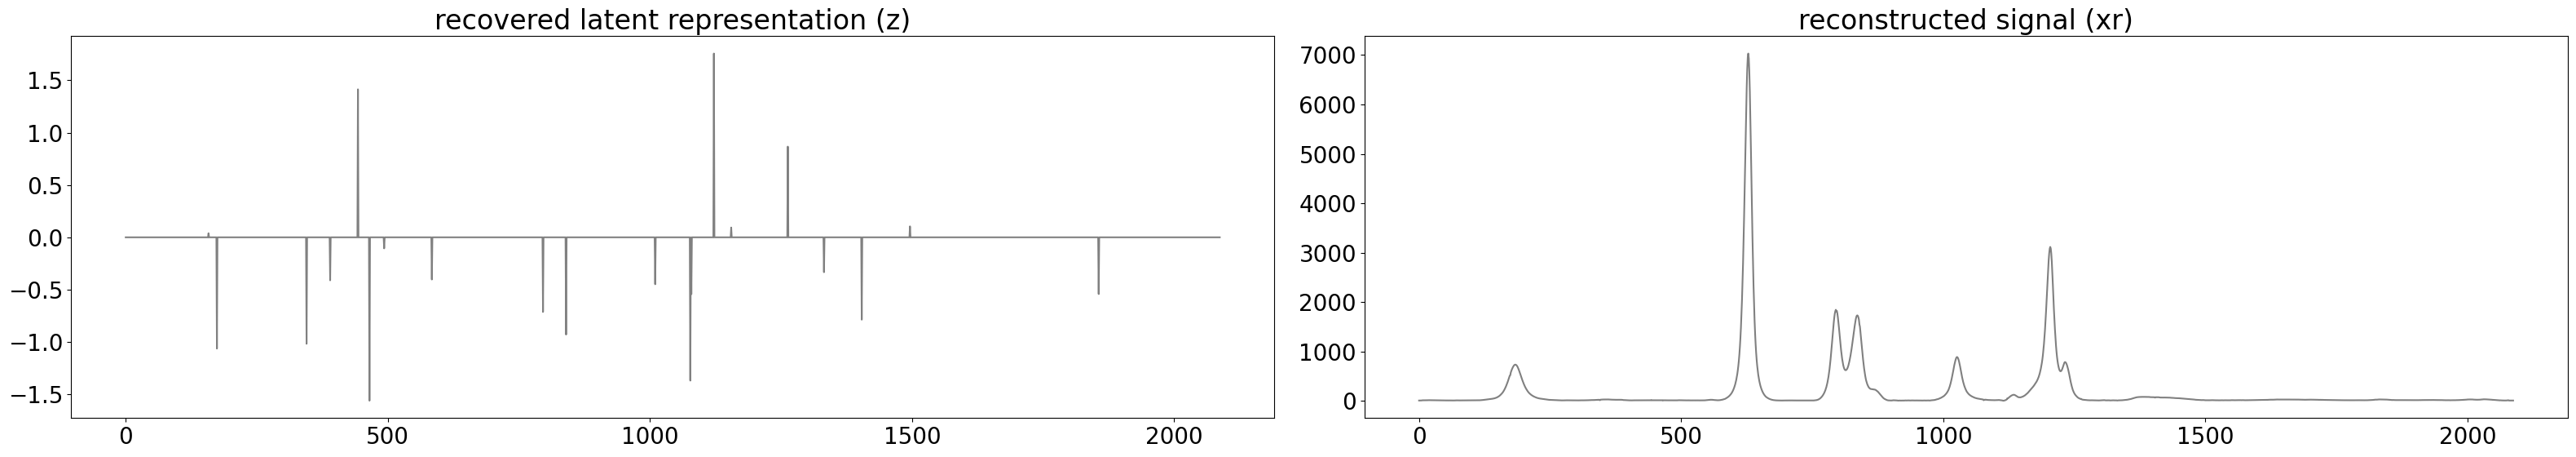


hyper-parameters:  (0.01, 'IDM', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:12<00:00,  9.61it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.01, 'IDM', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:12<00:00,  9.79it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.01, 'IDM', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 82.98it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.01, 'IDM', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:03<00:00, 35.05it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.01, 'DCT', 'LASSO', 0.1)


100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 367.11it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.01, 'DCT', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:25<00:00,  4.76it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.01, 'DCT', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:24<00:00,  4.86it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.01, 'DCT', 'OMP', 0)


100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 154.43it/s]


ACC =  0.49586776859504134

hyper-parameters:  (0.01, 'DCT', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:09<00:00, 12.50it/s]


ACC =  0.5206611570247934
Update best hparams. Acc improved from 0.512396694214876 to 0.5206611570247934


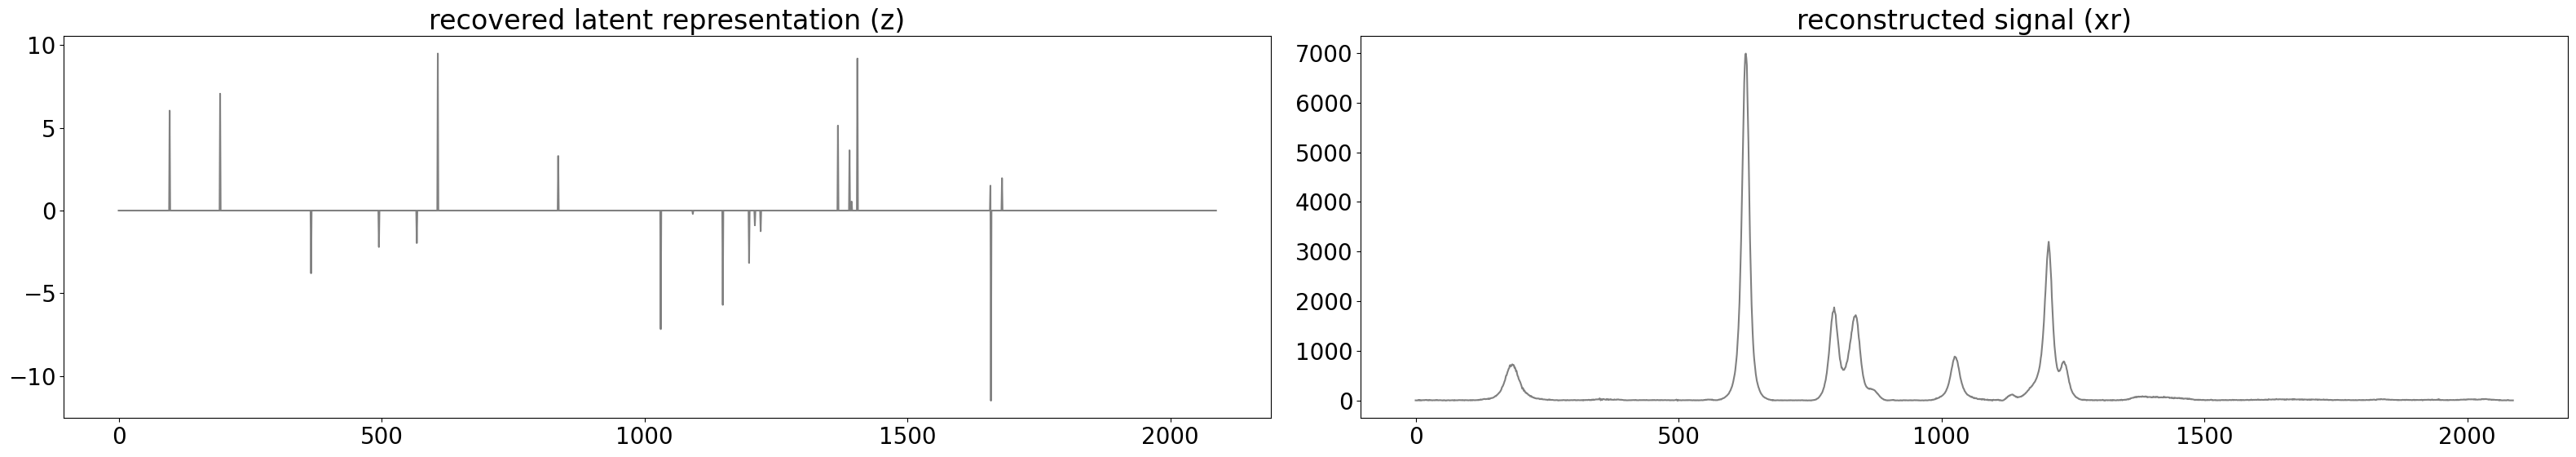


hyper-parameters:  (0.01, 'DFT', 'LASSO', 0.1)


100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 135.00it/s]


ACC =  0.5454545454545454
Update best hparams. Acc improved from 0.5206611570247934 to 0.5454545454545454


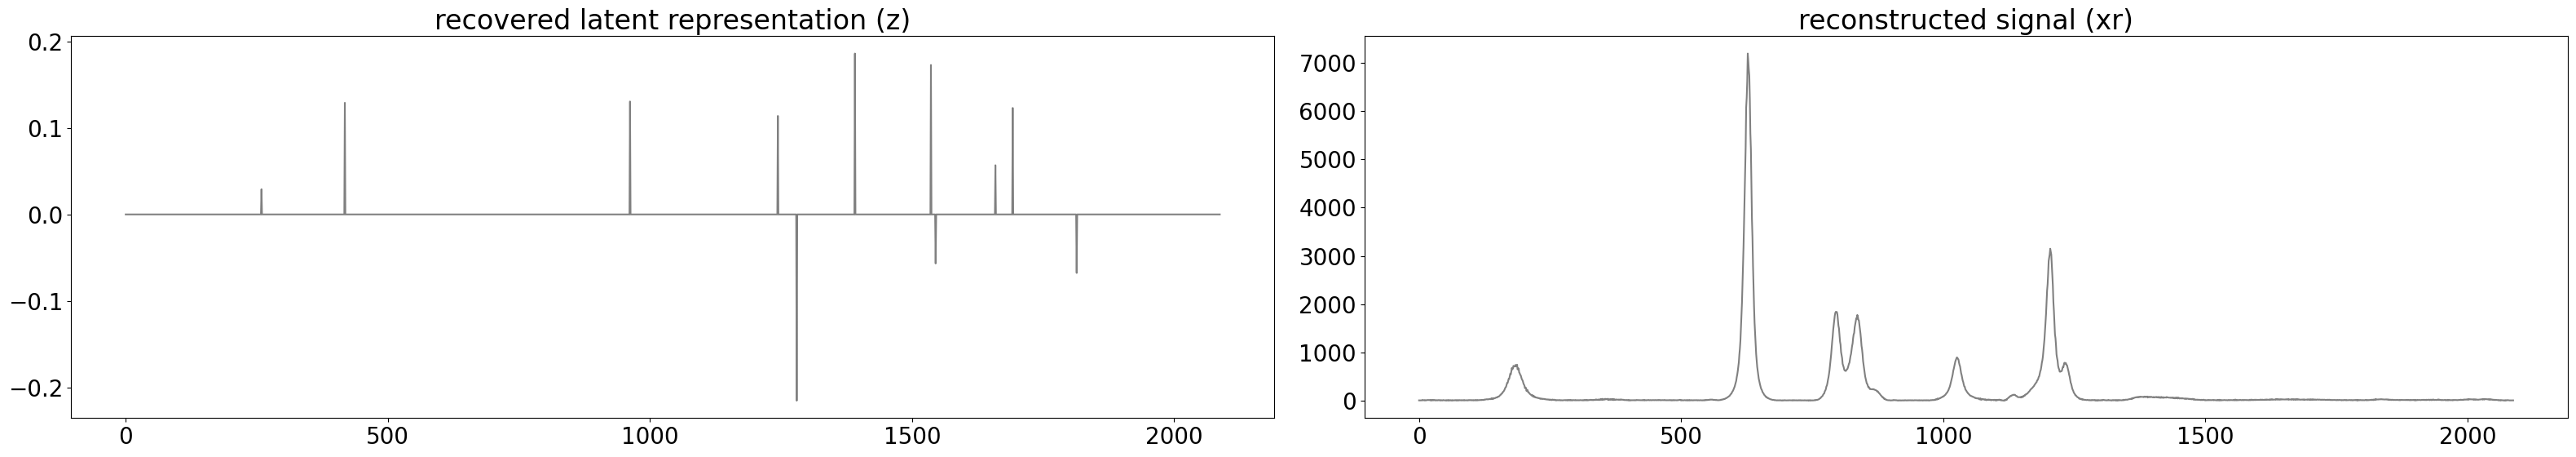


hyper-parameters:  (0.01, 'DFT', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:08<00:00, 13.46it/s]


ACC =  0.5289256198347108

hyper-parameters:  (0.01, 'DFT', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:09<00:00, 12.60it/s]


ACC =  0.5867768595041323
Update best hparams. Acc improved from 0.5454545454545454 to 0.5867768595041323


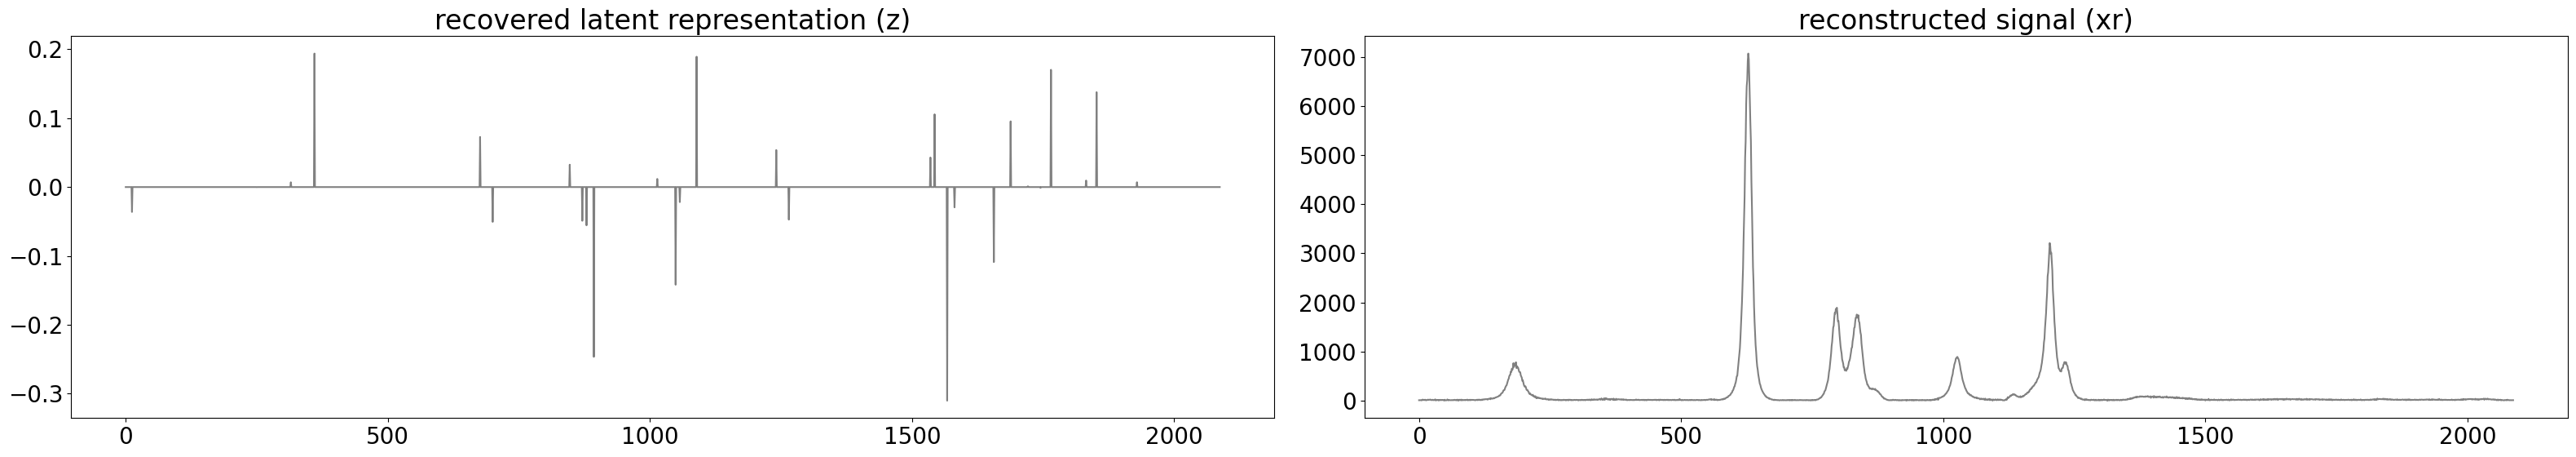


hyper-parameters:  (0.01, 'DFT', 'OMP', 0)


100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 171.42it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.01, 'DFT', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:10<00:00, 11.97it/s]


ACC =  0.6859504132231405
Update best hparams. Acc improved from 0.5867768595041323 to 0.6859504132231405


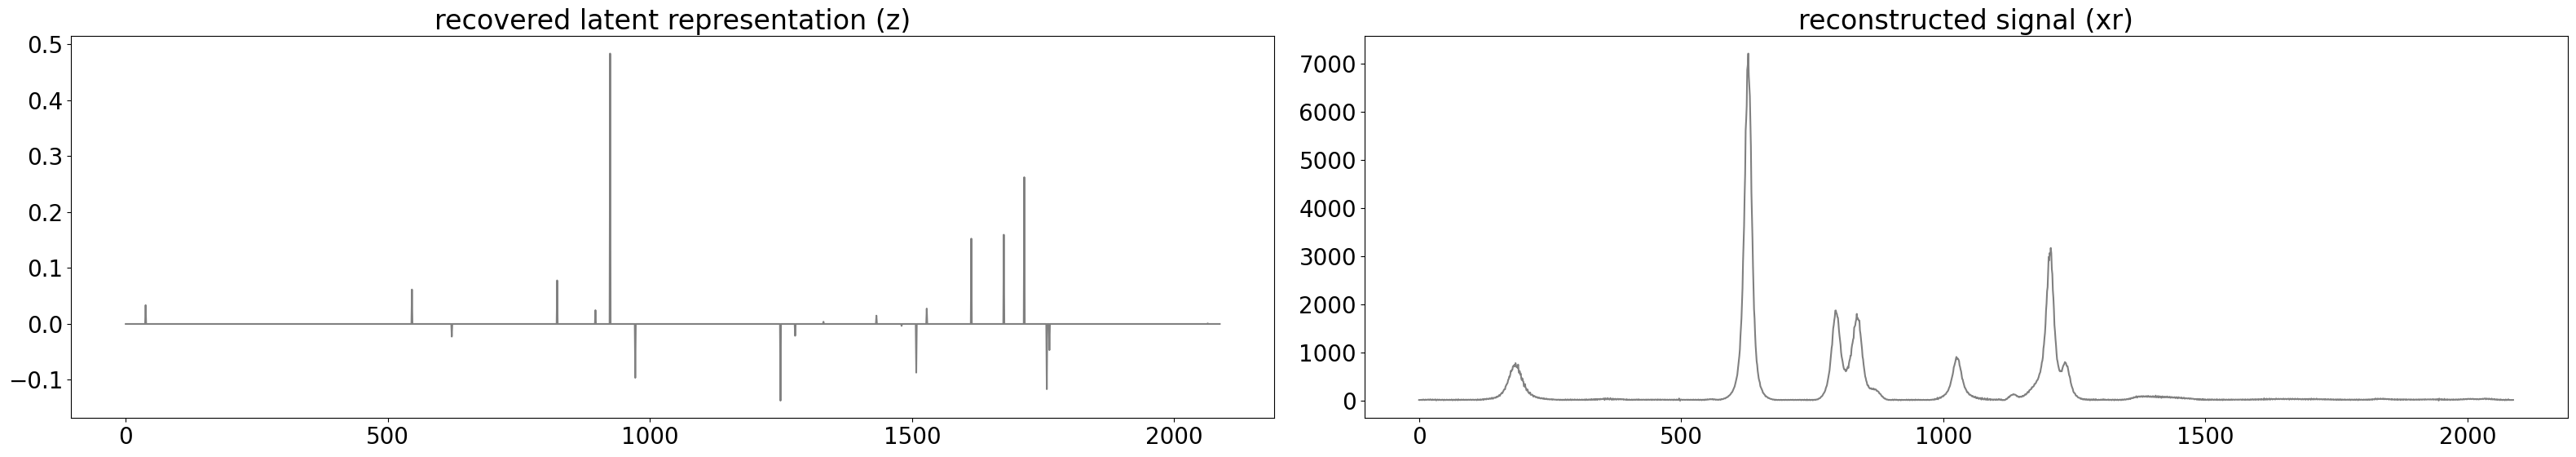


hyper-parameters:  (0.02, 'IDM', 'LASSO', 0.1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:02<00:00, 47.93it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.02, 'IDM', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:19<00:00,  6.27it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.02, 'IDM', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:16<00:00,  7.19it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.02, 'IDM', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:03<00:00, 33.69it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.02, 'IDM', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 24.25it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.02, 'DCT', 'LASSO', 0.1)


100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 265.84it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.02, 'DCT', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:27<00:00,  4.43it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.02, 'DCT', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:27<00:00,  4.38it/s]


ACC =  0.5206611570247934

hyper-parameters:  (0.02, 'DCT', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.51it/s]


ACC =  0.5950413223140496

hyper-parameters:  (0.02, 'DCT', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:16<00:00,  7.18it/s]


ACC =  0.6446280991735537

hyper-parameters:  (0.02, 'DFT', 'LASSO', 0.1)


100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 157.28it/s]


ACC =  0.5867768595041323

hyper-parameters:  (0.02, 'DFT', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:10<00:00, 11.44it/s]


ACC =  0.6363636363636364

hyper-parameters:  (0.02, 'DFT', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:10<00:00, 11.00it/s]


ACC =  0.6115702479338843

hyper-parameters:  (0.02, 'DFT', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 82.93it/s]


ACC =  0.5537190082644629

hyper-parameters:  (0.02, 'DFT', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:17<00:00,  6.85it/s]


ACC =  0.859504132231405
Update best hparams. Acc improved from 0.6859504132231405 to 0.859504132231405


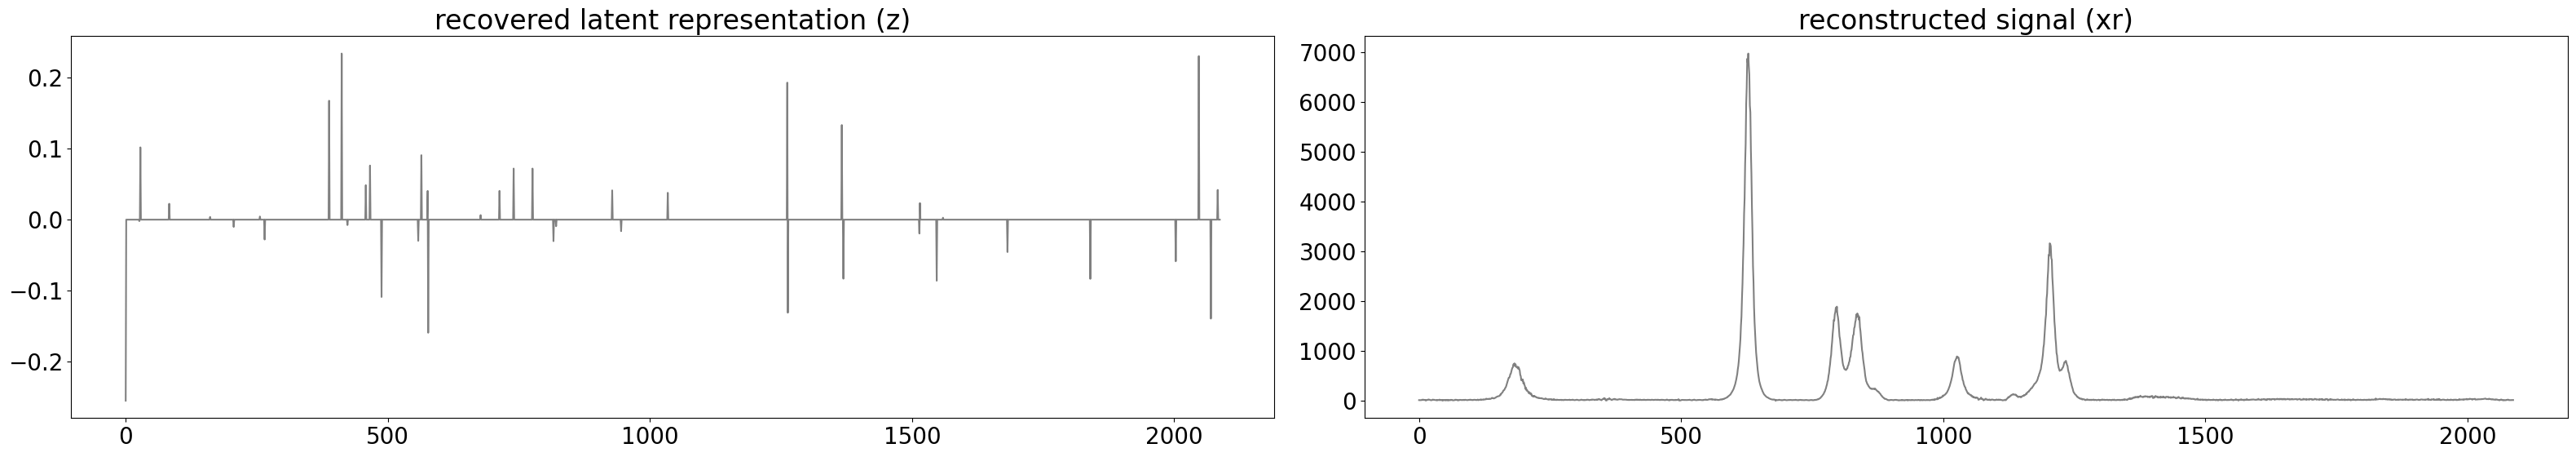


hyper-parameters:  (0.05, 'IDM', 'LASSO', 0.1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:09<00:00, 13.30it/s]


ACC =  0.8264462809917356

hyper-parameters:  (0.05, 'IDM', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:39<00:00,  3.09it/s]


ACC =  0.743801652892562

hyper-parameters:  (0.05, 'IDM', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:39<00:00,  3.07it/s]


ACC =  0.7603305785123967

hyper-parameters:  (0.05, 'IDM', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:12<00:00,  9.44it/s]


ACC =  0.7272727272727273

hyper-parameters:  (0.05, 'IDM', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:12<00:00,  9.91it/s]


ACC =  0.768595041322314

hyper-parameters:  (0.05, 'DCT', 'LASSO', 0.1)


100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 105.78it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.05, 'DCT', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:54<00:00,  2.21it/s]


ACC =  0.5289256198347108

hyper-parameters:  (0.05, 'DCT', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:51<00:00,  2.35it/s]


ACC =  0.5289256198347108

hyper-parameters:  (0.05, 'DCT', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 24.96it/s]


ACC =  0.743801652892562

hyper-parameters:  (0.05, 'DCT', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:54<00:00,  2.22it/s]


ACC =  0.8925619834710744
Update best hparams. Acc improved from 0.859504132231405 to 0.8925619834710744


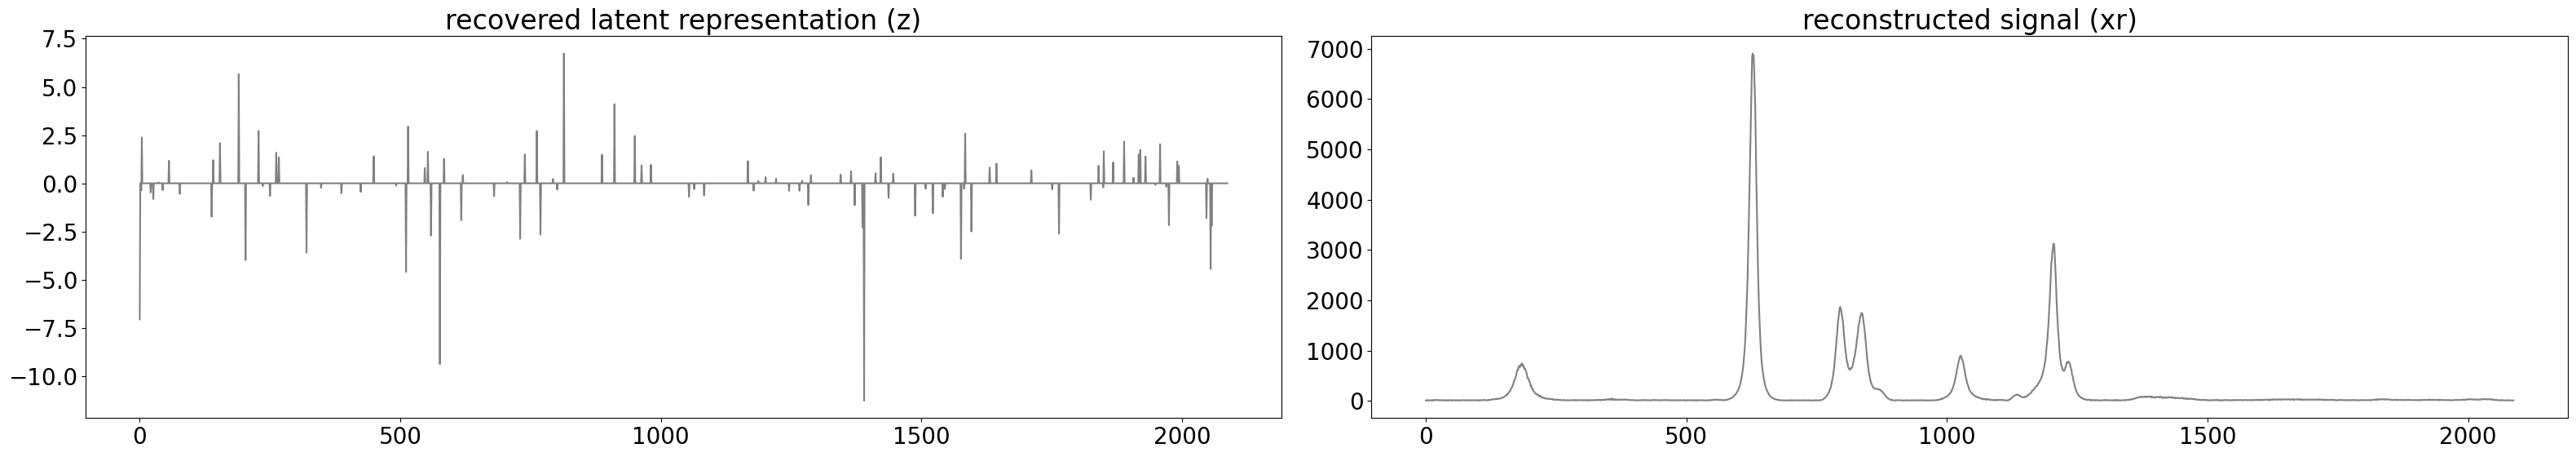


hyper-parameters:  (0.05, 'DFT', 'LASSO', 0.1)


100%|███████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 126.33it/s]


ACC =  0.7520661157024794

hyper-parameters:  (0.05, 'DFT', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:15<00:00,  7.66it/s]


ACC =  0.7768595041322314

hyper-parameters:  (0.05, 'DFT', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:15<00:00,  7.61it/s]


ACC =  0.7933884297520661

hyper-parameters:  (0.05, 'DFT', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 26.59it/s]


ACC =  0.71900826446281

hyper-parameters:  (0.05, 'DFT', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:58<00:00,  2.05it/s]


ACC =  0.9917355371900827
Update best hparams. Acc improved from 0.8925619834710744 to 0.9917355371900827


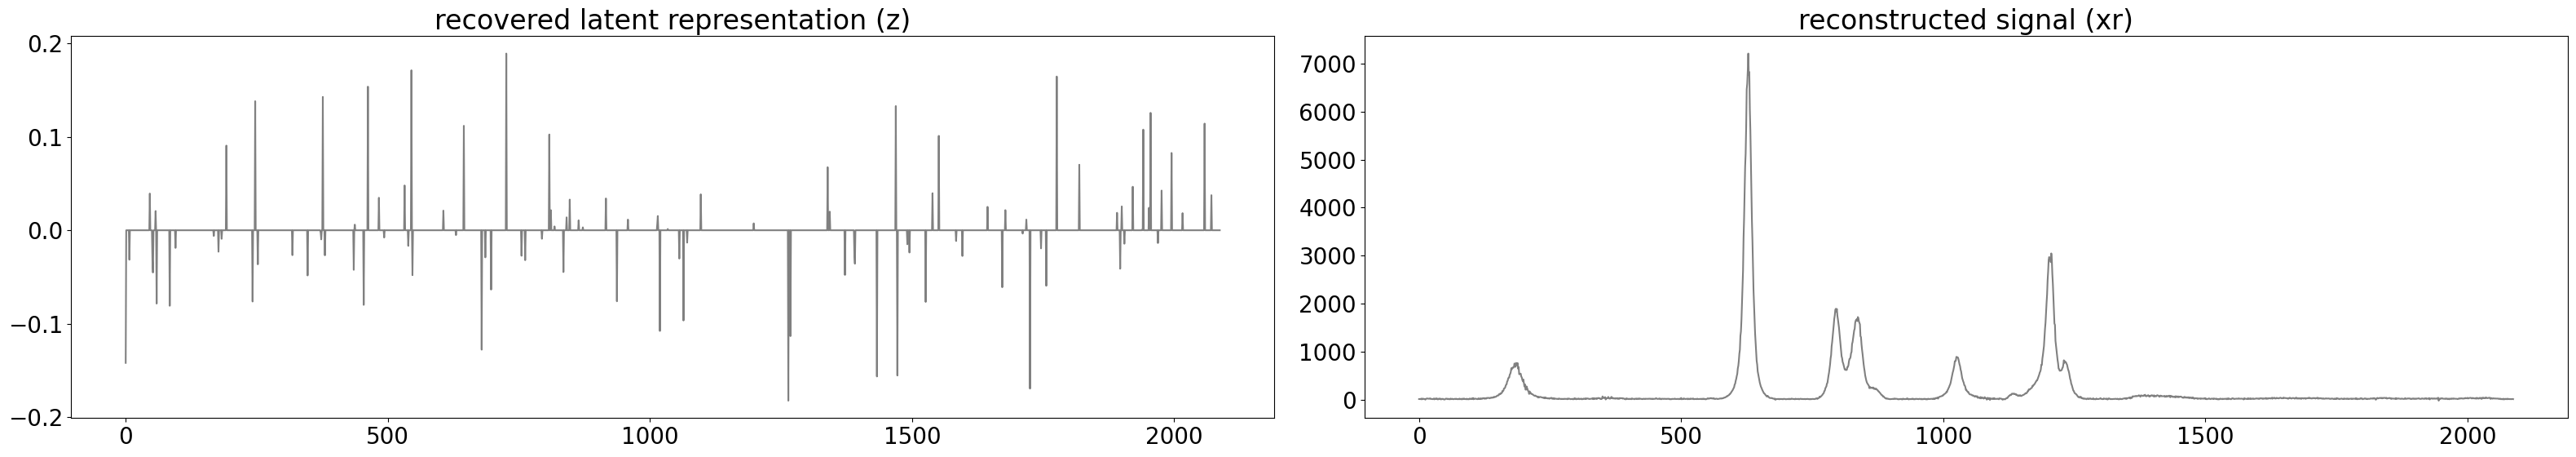


hyper-parameters:  (0.1, 'IDM', 'LASSO', 0.1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:24<00:00,  5.03it/s]


ACC =  1.0
Update best hparams. Acc improved from 0.9917355371900827 to 1.0


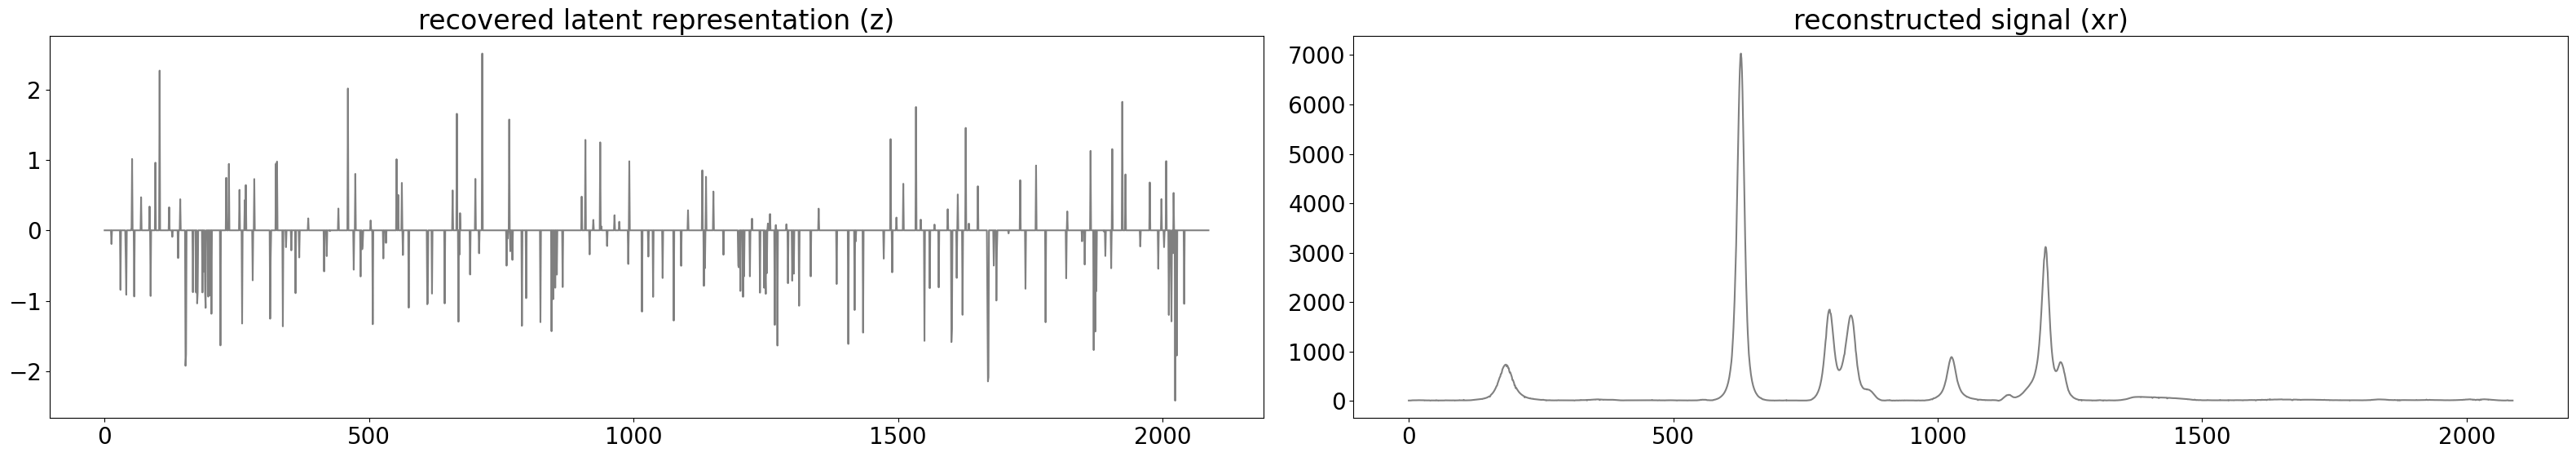


hyper-parameters:  (0.1, 'IDM', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [01:31<00:00,  1.32it/s]


ACC =  1.0

hyper-parameters:  (0.1, 'IDM', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [01:20<00:00,  1.51it/s]


ACC =  0.9917355371900827

hyper-parameters:  (0.1, 'IDM', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:35<00:00,  3.43it/s]


ACC =  1.0

hyper-parameters:  (0.1, 'IDM', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:24<00:00,  4.96it/s]


ACC =  1.0

hyper-parameters:  (0.1, 'DCT', 'LASSO', 0.1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.86it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.1, 'DCT', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [01:35<00:00,  1.27it/s]


ACC =  0.6528925619834711

hyper-parameters:  (0.1, 'DCT', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [01:33<00:00,  1.29it/s]


ACC =  0.5785123966942148

hyper-parameters:  (0.1, 'DCT', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:14<00:00,  8.56it/s]


ACC =  0.9504132231404959

hyper-parameters:  (0.1, 'DCT', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [02:55<00:00,  1.45s/it]


ACC =  1.0

hyper-parameters:  (0.1, 'DFT', 'LASSO', 0.1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 82.74it/s]


ACC =  0.8677685950413223

hyper-parameters:  (0.1, 'DFT', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:25<00:00,  4.83it/s]


ACC =  0.9586776859504132

hyper-parameters:  (0.1, 'DFT', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:25<00:00,  4.72it/s]


ACC =  0.9834710743801653

hyper-parameters:  (0.1, 'DFT', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:13<00:00,  8.69it/s]


ACC =  0.9173553719008265

hyper-parameters:  (0.1, 'DFT', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [03:06<00:00,  1.54s/it]


ACC =  1.0

hyper-parameters:  (0.3, 'IDM', 'LASSO', 0.1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [01:40<00:00,  1.20it/s]


ACC =  1.0

hyper-parameters:  (0.3, 'IDM', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [04:45<00:00,  2.36s/it]


ACC =  1.0

hyper-parameters:  (0.3, 'IDM', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [05:32<00:00,  2.75s/it]


ACC =  1.0

hyper-parameters:  (0.3, 'IDM', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [02:05<00:00,  1.03s/it]


ACC =  1.0

hyper-parameters:  (0.3, 'IDM', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [01:45<00:00,  1.15it/s]


ACC =  1.0

hyper-parameters:  (0.3, 'DCT', 'LASSO', 0.1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:05<00:00, 21.19it/s]


ACC =  0.512396694214876

hyper-parameters:  (0.3, 'DCT', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:49<00:00,  3.38s/it]


ACC =  0.9834710743801653

hyper-parameters:  (0.3, 'DCT', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [06:51<00:00,  3.40s/it]


ACC =  0.9669421487603306

hyper-parameters:  (0.3, 'DCT', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:24<00:00,  4.99it/s]


ACC =  1.0

hyper-parameters:  (0.3, 'DCT', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [27:19<00:00, 13.55s/it]


ACC =  1.0

hyper-parameters:  (0.3, 'DFT', 'LASSO', 0.1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 28.79it/s]


ACC =  0.859504132231405

hyper-parameters:  (0.3, 'DFT', 'LASSO', 1)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [01:15<00:00,  1.60it/s]


ACC =  1.0

hyper-parameters:  (0.3, 'DFT', 'LASSO', 10)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [01:19<00:00,  1.53it/s]


ACC =  1.0

hyper-parameters:  (0.3, 'DFT', 'OMP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [00:24<00:00,  4.88it/s]


ACC =  1.0

hyper-parameters:  (0.3, 'DFT', 'BP', 0)


100%|████████████████████████████████████████████████████████████████████████████████| 121/121 [26:33<00:00, 13.17s/it]

ACC =  1.0


({"(0.01, 'IDM', 'LASSO', 0.1)": 0.512396694214876,
  "(0.01, 'IDM', 'LASSO', 1)": 0.512396694214876,
  "(0.01, 'IDM', 'LASSO', 10)": 0.512396694214876,
  "(0.01, 'IDM', 'OMP', 0)": 0.512396694214876,
  "(0.01, 'IDM', 'BP', 0)": 0.512396694214876,
  "(0.01, 'DCT', 'LASSO', 0.1)": 0.512396694214876,
  "(0.01, 'DCT', 'LASSO', 1)": 0.512396694214876,
  "(0.01, 'DCT', 'LASSO', 10)": 0.512396694214876,
  "(0.01, 'DCT', 'OMP', 0)": 0.49586776859504134,
  "(0.01, 'DCT', 'BP', 0)": 0.5206611570247934,
  "(0.01, 'DFT', 'LASSO', 0.1)": 0.5454545454545454,
  "(0.01, 'DFT', 'LASSO', 1)": 0.5289256198347108,
  "(0.01, 'DFT', 'LASSO', 10)": 0.5867768595041323,
  "(0.01, 'DFT', 'OMP', 0)": 0.512396694214876,
  "(0.01, 'DFT', 'BP', 0)": 0.6859504132231405,
  "(0.02, 'IDM', 'LASSO', 0.1)": 0.512396694214876,
  "(0.02, 'IDM', 'LASSO', 1)": 0.512396694214876,
  "(0.02, 'IDM', 'LASSO', 10)": 0.512396694214876,
  "(0.02, 'IDM', 'OMP', 0)": 0.512396694214876,
  "(0.02, 'IDM', 'BP', 0)": 0.512396694214876,
 

In [1]:
from qsi import io
from cs1 import cs

from qsi import io
X, y, X_names, desc, labels = io.load_dataset('vintage_526', display = False)

cs.GridSearch_Dataset_Sensing_n_Recovery(X, y, ts = ['IDM', 'DCT', 'DFT'], 
ks = [0.01, 0.02, 0.05, 0.1, 0.3], 
solvers = ['LASSO', 'OMP', 'BP'],
L1s = [0.1, 1, 10])

(0.1, 'DCT/DFT/IDM', 'LASSO/BP/OMP') : ACC = 100%   当k达到0.1后，即使IDM也获得了100%的分类准确率。   

(0.02, 'DFT', 'BP', 0) : ACC = 86.0%  
(0.05, 'DFT', 'BP', 0) : ACC = 99.2% 

## Conclusion： 以分类准确率为目标，VAE将采样百分比降低到非自适应方法的1/5. Very impressive

## 2. An implementation based on `cvxpy`

In [11]:
from cs1.basis.common import dctmtx
from cs1 import cs
import torch
import cvxpy
import random
import numpy as np

def bp_reconstruct(PHI, xs): 
    
    PHI = np.array(PHI.cpu()) # ns x n
    n = PHI.shape[1]
    PSI = dctmtx(n,n,display = False)
    A = PHI@PSI
    
    xs = np.array(xs.cpu()).astype(np.double).flatten()
    # P, q = np.array(PHI.cpu()), np.array(xs.cpu()).astype(np.double).flatten()
    
    z = cvxpy.Variable(n)
    obj = cvxpy.Minimize(cvxpy.norm(z, 1))
    const = [A @ z == xs]
    
    # print(PHI.shape, xr.shape, xs.shape)
    
    prob = cvxpy.Problem(obj,const)
    _ = prob.solve()
    
    return z.value, PSI @ z.value

def bp_cs(x, k = 0.02, PHI_flavor = 'bernoulli'):
    
    n = len(x)
    ns = round(k*n)
    
    if PHI_flavor == 'gaussian' or PHI_flavor == 'normal':
    
        ######### Sensing matrix from Normal dist ############
        normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1/np.sqrt(n)])) # 构造N(0, 1/n)的感知矩阵
        PHI = normal.sample((ns,n)).squeeze().cuda() # squeeze对数据的维度进行压缩，去掉维数为1的的维度，默认是将所有为1的维度删掉
        # print('gaussian', PHI.size())
        
    else: # 'bernoulli'
        
        ######### Sensing matrix using the identity matrix ###########
        IDX = random.sample(range(n), ns)
        PHI = torch.Tensor( np.eye(n)[IDX] ).cuda().float()        
    
    normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([0.1/np.sqrt(n)]))
    noise = normal.sample((ns,)).cuda()

    xs = torch.mm(PHI, x) #  + noise
    xs.cuda()
        
    xr = bp_reconstruct(PHI, xs)
    # print(xs)
    
    return xr

In [ ]:
from tqdm import tqdm

ks = [0.001, 0.01, 0.1, 0.3]
accs = []

# for PHI_flavor in ['bernoulli', 'gaussian']:
for k in ks:
    
    Xr =[]
    Z = []
    
    for x in tqdm(X):
        z, xr = bp_cs(torch.from_numpy(x).view(-1,1).float().cuda(), k = k)
        Xr.append(xr)
        Z.append(z)
        
    Xr = scaler.inverse_transform( np.squeeze(np.array(Xr)) )
    X_restore = scaler.inverse_transform( X )

    acc = clf.score(Xr, y)
    print(k, ' ACC = ', acc)
    accs.append(acc)
    
    cs.plot_reconstructed(Z[0], X_restore[0])
    
plt.figure(figsize = (6, 2))
plt.scatter(ks, accs)
plt.show()

  2%|█▎                                                                                | 2/121 [00:16<16:04,  8.10s/it]

## Results:

We show results of basis pursuit with $100$ and $300$ measurements. For $m=100$ the reconstructions are useless, and for $m=300$ they are arguable decent.

Basis pursuit compares very poorly against the VAE. **However**, one should not forget that the VAE was trained beforehand on a large relevant dataset, whereas basis pursuit works with **no prior knowledge of the data**.

# Appendix

## 1. Other reconstruction algorithms: 

### MOD (Method of Optimal Directions)

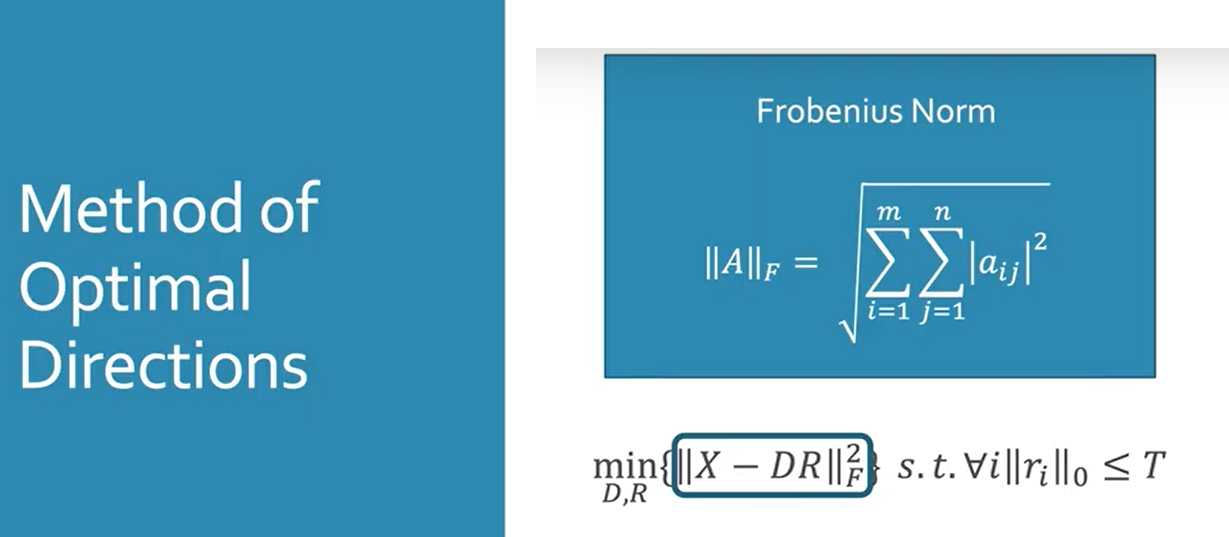

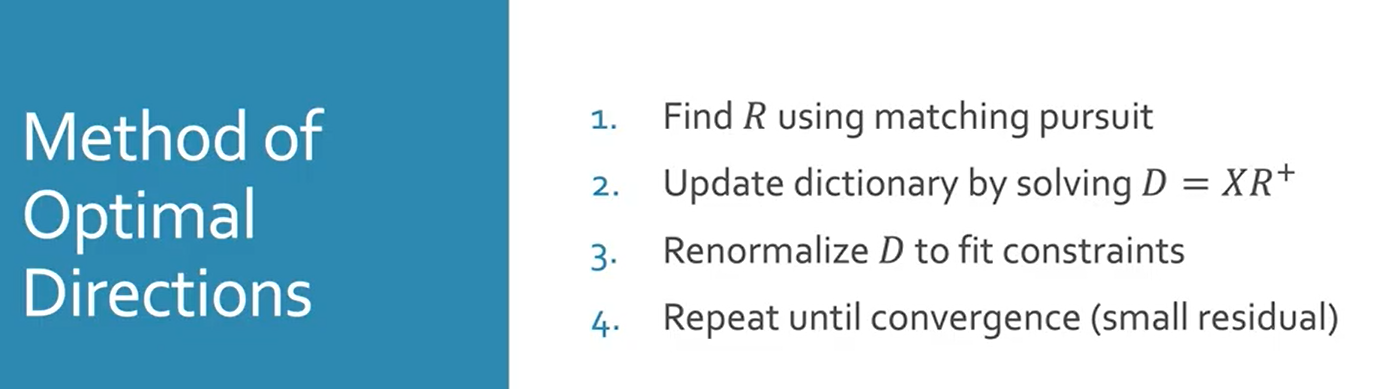

MOD uses matching pursuit. 

MP is a greedy algorithm. 

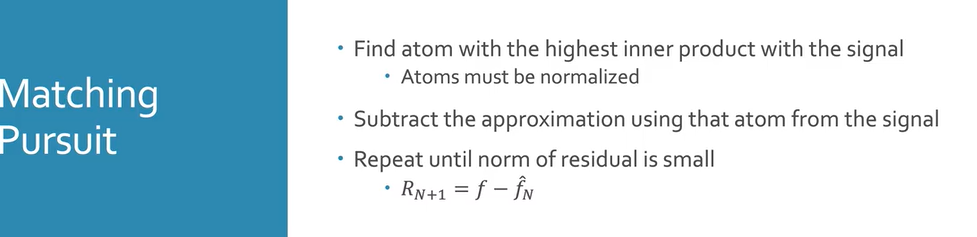

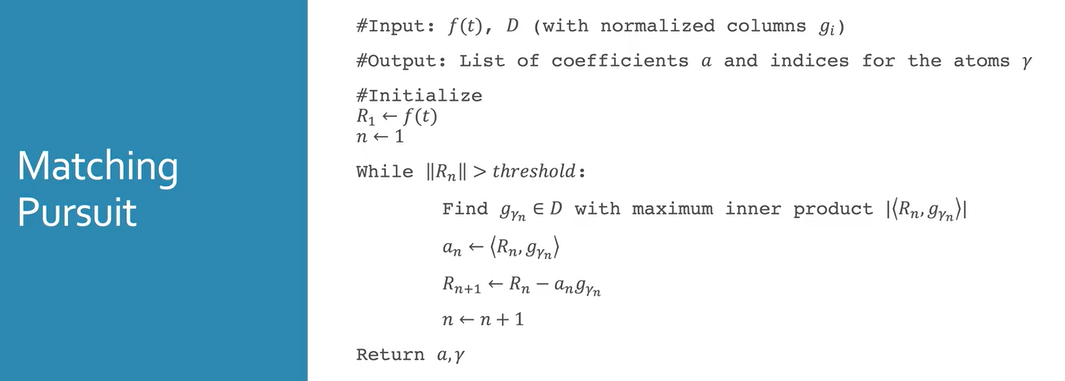

### K-SVD

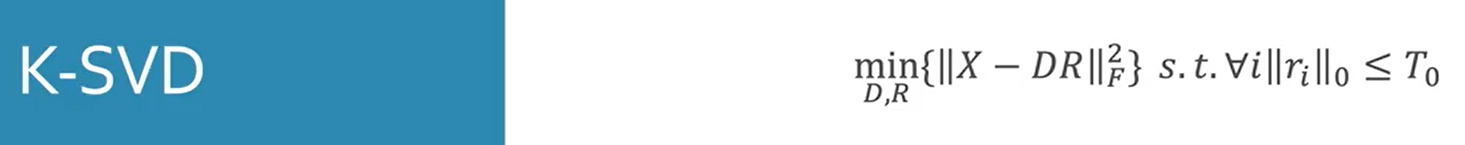 

It relaxes the K-means by allowing T0 (1 for k-means) elements to be non-zero

## Raman spectrometer

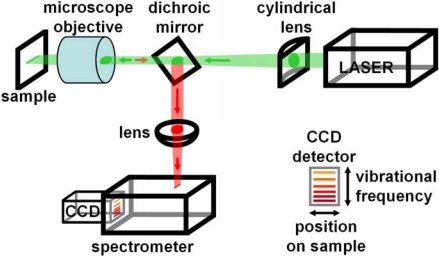

"
Schematic of Raman spectrometer. The displayed set-up focuses the illuminating laser (coloured green) down to a line on the sample (slit scanning mode), which can be replaced by a spot by removing the cylindrical lens. When a spot is illuminated at the sample, the Raman-shifted light (colored red) is filtered out from the laser light by a dichroic mirror, and dispersed along a vertical line on the two dimensional CCD detector. In slit-scanning mode, many spectra are acquired simultaneously: each position along the line on the sample produces a spectrum along the CCD detector.
"

## Vantage Liquor Dataset II - SPI MS

dataset: vintage_spi   
original x range : 5924. Using the first 3400 (0 - 100).   
x unit: m/z  

### 设备原理

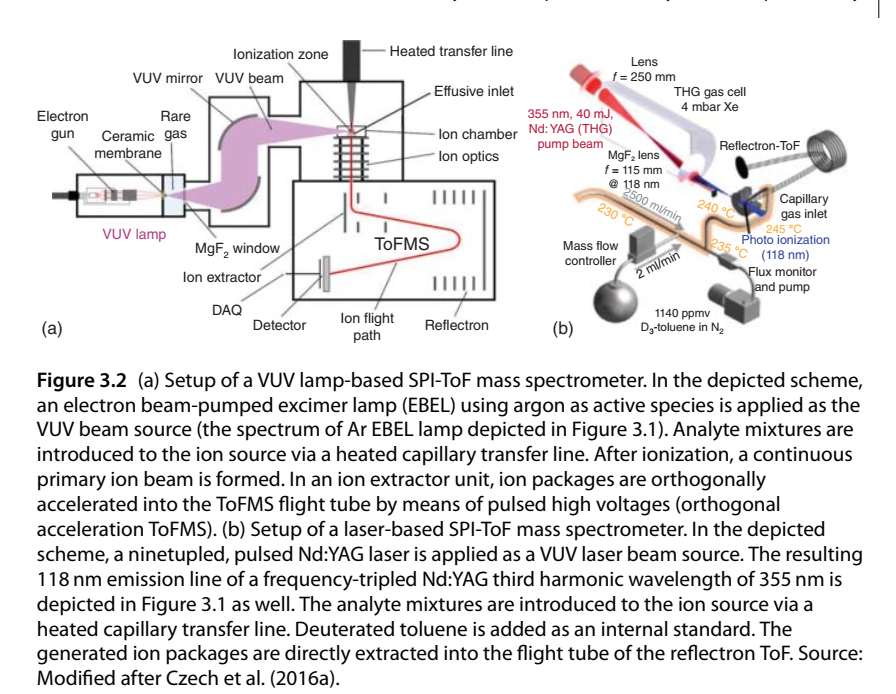

## Data Augmentation using SMOTE

## BP 和 BPDN/LASSO的区别

Differences between BP and Lasso can be seen when consider the different formulation of the problems.  

Basis Pursuit: $ min∥x∥_1 , s.t.,  Ax=b  $

If you have some noise in your data,you can relax the constraint to some degree and reformulate it:   
$ min∥x∥_1 $, s.t., $ ∥Ax−b∥_2≤ϵ $  
This problem is called Basis Pursuit Denoising (BPDN). For BP, b must be in the column space of A i.e. $ Ax=b $. So, BPDN is noise tolarable version of BP.  


In order to achieve Lasso formulation, Exchange the constraint and the objective of BPDN and bring the sparsity level:
$ min∥Ax−b∥_2 $, $ s.t., min∥x∥_1 ≤ ϵ $, which is the Lagrangean dual of $ min ∥Ax−b∥^2_2 + λ ∥x∥_1 $.    
The above problem is called Lasso. 

Considering sparsity inducing nature of l1 norm, one can see from the formulation that Lasso is suitable for feature selection.
Also, there is another formulation of lasso.The l1 norm is convex, so you can relax the constraint and bring it into objective function by introducing lagrange multipliers.
$ min ∥Ax−b∥^2_2 + λ ∥x∥_1 $

### Conclusion: 

BP is not the same as Lasso. BP is a linear program.   
BPDN/Lasso are quadratic programs. Lasso and BPDN are equivalent problems.

## OMP (Orthogonal Matching Pursuit)

